# Model Explainers - For Regression

## Lesson Objectives

By the end of this lesson students will be able to:
- Define a global vs local explanation
- Use the Shap package and interpret shap values.


## Model Explainers

- There are packages with the sole purpose of better understanding how machine learning models make their predictions.
- Generally, model explainers will take the model and some of your data and apply some iterative process to try to quantify how the features are influencing the model's output.

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
## Customization Options
# pd.set_option('display.float_format',lambda x: f"{x:,.4f}")
pd.set_option("display.max_columns",100)
plt.style.use(['fivethirtyeight','seaborn-talk'])
mpl.rcParams['figure.facecolor']='white'

## additional required imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, make_column_selector, ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn import metrics

from sklearn.base import clone

## fixing random for lesson generation
SEED = 321
np.random.seed(SEED)

In [2]:
## Adding folder above to path
import os, sys
sys.path.append(os.path.abspath('../../'))

## Load stack_functions with autoreload turned on
%load_ext autoreload
%autoreload 2
from CODE import stack_functions as sf
from CODE import prisoner_project_functions as pf

def show_code(function):
    import inspect 
    from IPython.display import display,Markdown, display_markdown
    code = inspect.getsource(function)
    md_txt = f"```python\n{code}\n```"
    return display(Markdown(md_txt))
    

In [3]:
## Load in the student erformance data
url = "https://docs.google.com/spreadsheets/d/e/2PACX-1vS6xDKNpWkBBdhZSqepy48bXo55QnRv1Xy6tXTKYzZLMPjZozMfYhHQjAcC8uj9hQ/pub?output=xlsx"

df = pd.read_excel(url,sheet_name='student-mat')
# df.drop(columns=['G1','G2'])
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   school      395 non-null    object 
 1   sex         395 non-null    object 
 2   age         395 non-null    float64
 3   address     395 non-null    object 
 4   famsize     395 non-null    object 
 5   Pstatus     395 non-null    object 
 6   Medu        395 non-null    float64
 7   Fedu        395 non-null    float64
 8   Mjob        395 non-null    object 
 9   Fjob        395 non-null    object 
 10  reason      395 non-null    object 
 11  guardian    395 non-null    object 
 12  traveltime  395 non-null    float64
 13  studytime   395 non-null    float64
 14  failures    395 non-null    float64
 15  schoolsup   395 non-null    object 
 16  famsup      395 non-null    object 
 17  paid        395 non-null    object 
 18  activities  395 non-null    object 
 19  nursery     395 non-null    o

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18.0,U,GT3,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,yes,no,no,4.0,3.0,4.0,1.0,1.0,3.0,6.0,5.0,6.0,6.0
1,GP,F,17.0,U,GT3,T,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,yes,yes,no,5.0,3.0,3.0,1.0,1.0,3.0,4.0,5.0,5.0,6.0
2,GP,F,15.0,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,3.0,yes,no,yes,no,yes,yes,yes,no,4.0,3.0,2.0,2.0,3.0,3.0,10.0,7.0,8.0,10.0
3,GP,F,15.0,U,GT3,T,4.0,2.0,health,services,home,mother,1.0,3.0,0.0,no,yes,yes,yes,yes,yes,yes,yes,3.0,2.0,2.0,1.0,1.0,5.0,2.0,15.0,14.0,15.0
4,GP,F,16.0,U,GT3,T,3.0,3.0,other,other,home,father,1.0,2.0,0.0,no,yes,yes,no,yes,yes,no,no,4.0,3.0,2.0,1.0,2.0,5.0,4.0,6.0,10.0,10.0


In [4]:
# ### Train Test Split
## Make x and y variables
drop_feats = ['G1','G2']
y = df['G3'].copy()
X = df.drop(columns=['G3',*drop_feats]).copy()

## train-test-split with random state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=SEED)


# ### Preprocessing + ColumnTransformer

## make categorical & numeric selectors
cat_sel = make_column_selector(dtype_include='object')
num_sel = make_column_selector(dtype_include='number')

## make pipelines for categorical vs numeric data
cat_pipe = make_pipeline(SimpleImputer(strategy='constant',
                                       fill_value='MISSING'),
                         OneHotEncoder(drop='if_binary', sparse=False))

num_pipe = make_pipeline(SimpleImputer(strategy='mean'))

## make the preprocessing column transformer
preprocessor = make_column_transformer((num_pipe, num_sel),
                                       (cat_pipe,cat_sel),
                                      verbose_feature_names_out=False)

## fit column transformer and run get_feature_names_out
preprocessor.fit(X_train)
feature_names = preprocessor.get_feature_names_out()

X_train_df = pd.DataFrame(preprocessor.transform(X_train), 
                          columns = feature_names, index = X_train.index)


X_test_df = pd.DataFrame(preprocessor.transform(X_test), 
                          columns = feature_names, index = X_test.index)
X_test_df.head(3)

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,school_MS,sex_M,address_U,famsize_LE3,Pstatus_T,Mjob_at_home,Mjob_health,Mjob_other,Mjob_services,Mjob_teacher,Fjob_at_home,Fjob_health,Fjob_other,Fjob_services,Fjob_teacher,reason_course,reason_home,reason_other,reason_reputation,guardian_father,guardian_mother,guardian_other,schoolsup_yes,famsup_yes,paid_yes,activities_yes,nursery_yes,higher_yes,internet_yes,romantic_yes
58,15.0,1.0,2.0,1.0,2.0,0.0,4.0,3.0,2.0,1.0,1.0,5.0,2.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0
338,18.0,3.0,3.0,1.0,4.0,0.0,5.0,3.0,3.0,1.0,1.0,1.0,7.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0
291,17.0,4.0,3.0,1.0,3.0,0.0,4.0,2.0,2.0,1.0,2.0,3.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0


In [5]:
## fit random fores
from sklearn.ensemble import RandomForestRegressor
rf_reg = RandomForestRegressor()
rf_reg.fit(X_train_df,y_train)
sf.evaluate_regression(rf_reg,X_test_df,y_test, warn=False,
                       X_train=X_train_df, y_train=y_train)#linreg(rf_reg,X_train_zips,y_train,X_test_zips,y_test)

      Train   Test  Delta
R^2   0.910  0.085 -0.825
RMSE  1.405  4.023  2.618


Fjob_health          0.001351
guardian_mother      0.004300
reason_other         0.004932
guardian_father      0.005284
reason_home          0.005356
internet_yes         0.005659
Pstatus_T            0.006196
paid_yes             0.007169
address_U            0.007630
Mjob_health          0.007761
Mjob_other           0.007970
famsize_LE3          0.008351
Fjob_services        0.008621
Mjob_teacher         0.009024
Dalc                 0.009191
school_MS            0.009252
nursery_yes          0.009272
Fjob_other           0.009453
Mjob_services        0.010012
activities_yes       0.010288
Fjob_teacher         0.010371
guardian_other       0.010720
Fjob_at_home         0.010922
romantic_yes         0.012431
famsup_yes           0.013015
higher_yes           0.014331
reason_reputation    0.015734
Fedu                 0.020560
sex_M                0.021505
famrel               0.021921
reason_course        0.022823
Mjob_at_home         0.023137
schoolsup_yes        0.023192
Medu      

### Loading Joblib of Regressions from Lesson 04

In [6]:
import joblib
## If showing joblib in prior lesson, this cell will be included and further explained
loaded_data = joblib.load("../3_Feature_Importance/lesson_03.joblib")
loaded_data.keys()

dict_keys(['X_train', 'y_train', 'X_test', 'y_test', 'preprocessor', 'lin_reg', 'rf_reg'])

In [7]:
## If showing joblib in prior lesson, this cell will be included and further explained
X_train_reg = loaded_data['X_train'].copy()
y_train_reg = loaded_data['y_train'].copy()
X_test_df_reg = loaded_data['X_test'].copy()
y_test_reg = loaded_data['y_test'].copy()
lin_reg = loaded_data['lin_reg']
rf_reg = loaded_data['rf_reg']


## Using SHAP for Model Interpretation

- SHAP (SHapley Additive exPlanations)) 
    - [Repository](https://github.com/slundberg/shap)
    - [Documentation](https://shap.readthedocs.io/en/latest/?badge=latest)
  

- SHAP uses game theory to calcualte Shapely values for each feature in the dataset. 
- Shapely values are calculated by iteratively testing each feature's contribution to the model by comparing the model's  performance with vs. without the feature. (The "marginal contribution" of the feature to the model's performance).

#### Papers, Book Excerpts, and  Blogs
- [White Paper on Shapely Values](https://arxiv.org/abs/1705.07874)
    
- [Intepretable Machine Learning Book - Section on SHAP](https://christophm.github.io/interpretable-ml-book/shap.html)
    
- Towards Data Science Blog Posts:
    - [Explain Your Model with SHAP Values](https://towardsdatascience.com/explain-your-model-with-the-shap-values-bc36aac4de3d)

    - [Explain Any Model with SHAP KernelExplaibner](https://towardsdatascience.com/explain-any-models-with-the-shap-values-use-the-kernelexplainer-79de9464897a)

#### Videos/Talks:
- Explaining Machine Learning Models (in general).
    - ["Open the Black Box: an intro to Model Interpretability with LIME and SHAP](https://youtu.be/C80SQe16Rao)
- Understanding Shapely/SHAP Values:
    - [AI Simplified: SHAP Values in Machine Learning ](https://youtu.be/Tg8aPwPPJ9c)- (Intuitive Explanation)
    - [Explainable AI explained! | #4 SHAP  ](https://youtu.be/9haIOplEIGM)- (Math Calculation Explanation)

### How To Use Shap


- Import and initialize javascript:

```python
import shap 
shap.initjs()
```

In [8]:
import shap
shap.initjs()

### Shap Explainers

- shap has several types of model explainers that are optimized for different types of models. 


#### Explainers and their use cases:


| Explainer                         | Description                                                                                    |
|:----------------------------------|:-----------------------------------------------------------------------------------------------|
| shap.Explainer                    | Uses Shapley values to explain any machine learning model or python function.                  |
| shap.explainers.Tree              | Uses Tree SHAP algorithms to explain the output of ensemble tree models.                       |
| shap.explainers.Linear            | Computes SHAP values for a linear model, optionally accounting for inter-feature correlations. |
| shap.explainers.Permutation       | This method approximates the Shapley values by iterating through permutations of the inputs.   

<!-- - Uses game theory to explain feature importance and how a feature steered a model's prediction(s) by removing each feature and seeing the effect on the error.

- SHAP has:
    - `TreeExplainer`:
        - compatible with sckit learn, xgboost, Catboost
    - `KernelExplainer`:
        - compatible with "any" model
         -->


- See [this blog post](https://towardsdatascience.com/explain-your-model-with-the-shap-values-bc36aac4de3d) for intro to topic and how to use with trees

- For non-tree/random forest models [see this follow up post]( https://towardsdatascience.com/explain-any-models-with-the-shap-values-use-the-kernelexplainer-79de9464897a)

        

### Preparing Data for Shap

- Shap's approach to explaining models can be very resource-intensive for complex models such as our RandomForest.
- To get around this issue, shap includes a convenient smapling function to save a small sample from one of our X variables.

In [9]:
X_shap = shap.sample(X_train_df,nsamples=200,random_state=321)
X_shap

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,school_MS,sex_M,address_U,famsize_LE3,Pstatus_T,Mjob_at_home,Mjob_health,Mjob_other,Mjob_services,Mjob_teacher,Fjob_at_home,Fjob_health,Fjob_other,Fjob_services,Fjob_teacher,reason_course,reason_home,reason_other,reason_reputation,guardian_father,guardian_mother,guardian_other,schoolsup_yes,famsup_yes,paid_yes,activities_yes,nursery_yes,higher_yes,internet_yes,romantic_yes
355,18.0,3.0,3.0,1.0,2.0,0.0,5.0,3.0,4.0,1.0,1.0,5.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0
354,17.0,4.0,3.0,2.0,2.0,0.0,4.0,5.0,5.0,1.0,3.0,2.0,4.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
328,17.0,4.0,4.0,1.0,3.0,0.0,5.0,4.0,4.0,1.0,3.0,4.0,7.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
231,17.0,2.0,2.0,2.0,2.0,0.0,4.0,5.0,2.0,1.0,1.0,1.0,4.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
312,19.0,1.0,2.0,1.0,2.0,1.0,4.0,5.0,2.0,2.0,2.0,4.0,3.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210,19.0,3.0,3.0,1.0,4.0,0.0,4.0,3.0,3.0,1.0,2.0,3.0,10.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
236,17.0,2.0,2.0,1.0,2.0,0.0,4.0,4.0,2.0,5.0,5.0,4.0,4.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
10,15.0,4.0,4.0,1.0,2.0,0.0,3.0,3.0,3.0,1.0,2.0,2.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0
13,15.0,4.0,3.0,2.0,2.0,0.0,5.0,4.0,3.0,1.0,2.0,3.0,2.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0


In [10]:
## get the corresponding y-values
y_shap = y_train.loc[X_shap.index]
y_shap

355     9.0
354    11.0
328     9.0
231    11.0
312    11.0
       ... 
210     8.0
236    13.0
10      9.0
13     11.0
372    11.0
Name: G3, Length: 200, dtype: float64

### Explaining Our RandomForest


1. Create a shap explainer using your fit model.

```python
explainer = shap.TreeExplainer(rf_reg)
```

2. Get shapely values from explainer for your training data

```python
shap_values = explainer(X_shap)
```            

3. Select which type of the available plots you'd like to visualize

    
- **Types of Plots:**
    - `summary_plot()`
    - `dependence_plot()`
    - `force_plot()` for a given observation
    - `force_plot()` for all data
    
  

In [11]:
X_shap = X_train_df.copy()#shap.sample(X_train_df,nsamples=200,random_state=SEED)

explainer = shap.TreeExplainer(rf_reg)
shap_values = explainer(X_shap,y_shap)
shap_values[0]

.values =
array([-2.65129202e-03,  3.37739374e-02, -1.66913694e-02,  4.04224947e-02,
       -8.89278699e-02,  8.22963912e-01, -2.19713066e-02,  9.46616336e-03,
       -1.05073602e-01,  4.45105221e-02,  7.95999848e-02,  6.99744889e-01,
        1.05407076e+00,  7.37235898e-03, -1.65178625e-01,  1.09019192e-01,
        6.88803146e-02, -8.73117299e-03,  1.44210492e-01, -4.05021571e-02,
        8.44343694e-03, -5.94057998e-02,  9.03834608e-02,  2.51376396e-02,
        1.69540791e-03, -5.10195738e-02, -2.51987310e-03, -3.91344713e-02,
        1.97009755e-01, -3.56228354e-03, -2.04581060e-02,  2.76732166e-01,
       -1.81765629e-03,  1.43730639e-02,  5.16251179e-02,  1.98845113e-01,
        2.61826118e-01, -5.57521403e-04, -2.41598627e-02,  3.22229694e-02,
        9.33188335e-03,  3.45140981e-02,  7.30116122e-02])

.base_values =
array([10.34317568])

.data =
array([17.,  3.,  2.,  2.,  2.,  0.,  4.,  4.,  4.,  1.,  3.,  1.,  2.,
        0.,  0.,  1.,  1.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  

In [12]:
X_shap.shape

(296, 43)

In [13]:
shap_values.shape

(296, 43)

- We can see that shap calculated values for every row/column in our X_shap variable.
- What does the first row's shap values look like?

In [14]:
shap_values[0]

.values =
array([-2.65129202e-03,  3.37739374e-02, -1.66913694e-02,  4.04224947e-02,
       -8.89278699e-02,  8.22963912e-01, -2.19713066e-02,  9.46616336e-03,
       -1.05073602e-01,  4.45105221e-02,  7.95999848e-02,  6.99744889e-01,
        1.05407076e+00,  7.37235898e-03, -1.65178625e-01,  1.09019192e-01,
        6.88803146e-02, -8.73117299e-03,  1.44210492e-01, -4.05021571e-02,
        8.44343694e-03, -5.94057998e-02,  9.03834608e-02,  2.51376396e-02,
        1.69540791e-03, -5.10195738e-02, -2.51987310e-03, -3.91344713e-02,
        1.97009755e-01, -3.56228354e-03, -2.04581060e-02,  2.76732166e-01,
       -1.81765629e-03,  1.43730639e-02,  5.16251179e-02,  1.98845113e-01,
        2.61826118e-01, -5.57521403e-04, -2.41598627e-02,  3.22229694e-02,
        9.33188335e-03,  3.45140981e-02,  7.30116122e-02])

.base_values =
array([10.34317568])

.data =
array([17.,  3.,  2.,  2.,  2.,  0.,  4.,  4.,  4.,  1.,  3.,  1.,  2.,
        0.,  0.,  1.,  1.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  

- Notice above that we do not seem to have a simple numpy array. 

In [15]:
type(shap_values[0])

shap._explanation.Explanation

In [16]:
explanation_0 = shap_values[0]
explanation_0

.values =
array([-2.65129202e-03,  3.37739374e-02, -1.66913694e-02,  4.04224947e-02,
       -8.89278699e-02,  8.22963912e-01, -2.19713066e-02,  9.46616336e-03,
       -1.05073602e-01,  4.45105221e-02,  7.95999848e-02,  6.99744889e-01,
        1.05407076e+00,  7.37235898e-03, -1.65178625e-01,  1.09019192e-01,
        6.88803146e-02, -8.73117299e-03,  1.44210492e-01, -4.05021571e-02,
        8.44343694e-03, -5.94057998e-02,  9.03834608e-02,  2.51376396e-02,
        1.69540791e-03, -5.10195738e-02, -2.51987310e-03, -3.91344713e-02,
        1.97009755e-01, -3.56228354e-03, -2.04581060e-02,  2.76732166e-01,
       -1.81765629e-03,  1.43730639e-02,  5.16251179e-02,  1.98845113e-01,
        2.61826118e-01, -5.57521403e-04, -2.41598627e-02,  3.22229694e-02,
        9.33188335e-03,  3.45140981e-02,  7.30116122e-02])

.base_values =
array([10.34317568])

.data =
array([17.,  3.,  2.,  2.,  2.,  0.,  4.,  4.,  4.,  1.,  3.,  1.,  2.,
        0.,  0.,  1.,  1.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  

- Each entry in the shap_values array is new type of object called an Explanation.
    - Each Explanation has:
        - values:the shap values calculated for this observation/row. 
            - For classification models, there is a column with values for each target.
        - base_values: the final shap output value
        - data: the original input feature

In [17]:
## Showing .data is the same as the raw X_shap
explanation_0.data

array([17.,  3.,  2.,  2.,  2.,  0.,  4.,  4.,  4.,  1.,  3.,  1.,  2.,
        0.,  0.,  1.,  1.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,
        0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,
        1.,  1.,  1.,  0.])

In [18]:
X_shap.iloc[0].values

array([17.,  3.,  2.,  2.,  2.,  0.,  4.,  4.,  4.,  1.,  3.,  1.,  2.,
        0.,  0.,  1.,  1.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,
        0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,
        1.,  1.,  1.,  0.])

In [19]:
## showing the .values
pd.Series(explanation_0.values,index=X_shap.columns)

age                 -0.002651
Medu                 0.033774
Fedu                -0.016691
traveltime           0.040422
studytime           -0.088928
failures             0.822964
famrel              -0.021971
freetime             0.009466
goout               -0.105074
Dalc                 0.044511
Walc                 0.079600
health               0.699745
absences             1.054071
school_MS            0.007372
sex_M               -0.165179
address_U            0.109019
famsize_LE3          0.068880
Pstatus_T           -0.008731
Mjob_at_home         0.144210
Mjob_health         -0.040502
Mjob_other           0.008443
Mjob_services       -0.059406
Mjob_teacher         0.090383
Fjob_at_home         0.025138
Fjob_health          0.001695
Fjob_other          -0.051020
Fjob_services       -0.002520
Fjob_teacher        -0.039134
reason_course        0.197010
reason_home         -0.003562
reason_other        -0.020458
reason_reputation    0.276732
guardian_father     -0.001818
guardian_m

## Shap Visualizations - Regression

### Summary Plot

```python
## For normal bar graph of importance:
shap.summary_plot(shap_values, features=X_shap, plot_type='bar')

## For detail Shapely value visuals:
shap.summary_plot(shap_values, features=X_shap)
```
  

**`shap.summary_plot`**
> - Feature importance: Variables are ranked in descending order.
- Impact: The horizontal location shows whether the effect of that value is associated with a higher or lower prediction.
- Original value: Color shows whether that variable is high (in red) or low (in blue) for that observation.


>- **IMPORTANT NOTE:** You may need to slice out the correct shap_values for the target class. (by default explainer.shap_values seems to return a list for a binary classification, one set of shap values for each class).
    - This will cause issues like the summary plot having a bar with an equal amount of blue and red for each class. 
    - To fix, slice out the correct matrix from shap_values [0,1]


- First, let's examine a simple version of our shap values. 
    - By using the plot_type="bar" version of the summary plot, we get something that looks very similar to the feature importances we discussed previously. 
    

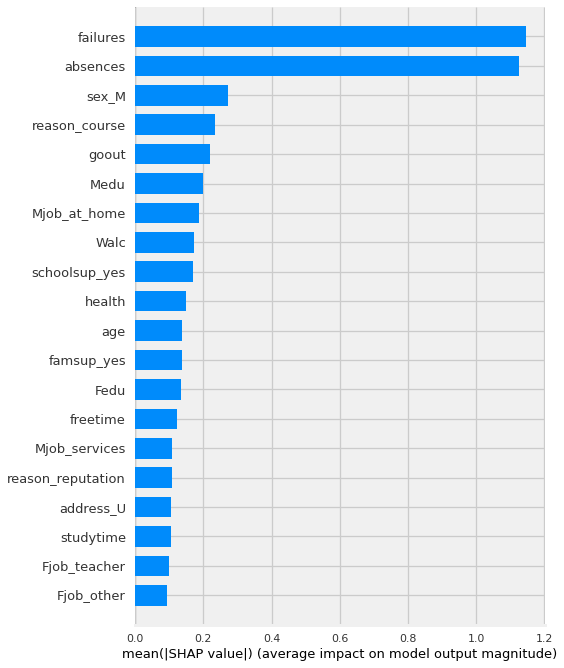

In [20]:
shap.summary_plot(shap_values,features= X_shap,plot_type='bar')

- In this case, it is using the magnitude of the average shap values to to show which features had the biggest impact on the model's predictions.
    - Like feature importance and permutation importance, this visualization is not indicating which **direction** the features push the predict.
    
- Now, let's examine the "dot" version of the summary plot. 
    - By removing the plot_type argument, we are using the default, which is "dot". 
        - We could explicitly specify plot_type="dot".
            - There are also additional plot types that we will not be discussing in this lesson (e.g. "violin","compact_dot")

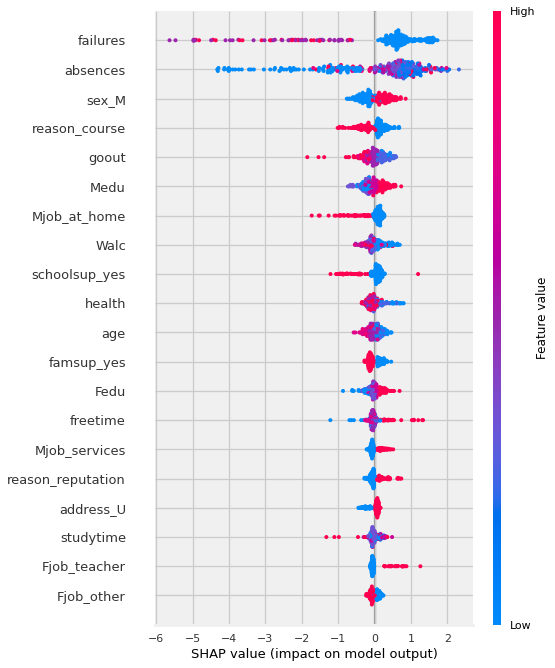

In [21]:
shap.summary_plot(shap_values,X_shap)

Now THAT is a lot more nuanced of a visualization!
Let's break down how to interpret the visual above.

### Reading Summary Plots

- In the summary plot above:
    - Each dot represents an observation/row (in this case, a student).
    - The **features are plotting on the y-axis**, and are sorted from the most
impactful features to the least (from top to bottom).
    - The **calculated Shapely values for each observation** are plotted on the x-axis. The most positive the value the more positive...
    `bookmark`
    - For each feature, the original values of that feature are represented with color. 
        - Using the default colormap, blue represents the lowest value in the column and red represents the highest. 
            - For one hot encoded categories, blue=0, red = 1.
            - For numeric features: the shade of the color indicates where it falls in the feature's distribution.


### Summary Plot Interpretation

- fewer prior failures = higher final grade
-`Q: what is going on with absences?`
    - why are some of the lowest values leading to negative shap value (meaning a decreased final score)?
    - Why would less absences meaning a lower final grade?
        -  🤔 Did the student not spend all 3 years at the school??
- sex_M: 
    - males get a higher grade
- reason_course:
    - if a student attends the school because of a specific course, they have a lower final grade.
    
- goout: 
    - the more a student goes out, the lower the grade.
    
- Medu (mother's education):
    - Higher mother's ed the higher the grade
- Mjob_at_home:
    - Mother at home leads to lower grades.
- Walc:
    Lower weekend alcohol consumption "causes" higher grade
   

### Dependence Plots


Shap also includes the `shap.dependence_plot`
which show how the model output varies by a specific feature. By passing the function a feature name, it will automatically determine what features may driving the interactions with the selected feature. It will encode the interaction feature as color.
```python
## To Auto-Select Feature Most correlated with a specific feature, just pass the desired feature's column name.

shap.dependence_plot('age', shap_values, X_shap)
```

- TO DO:
    - There is a way to specifically call out multiple features but I wasn't able to summarize it quickly for this nb
```

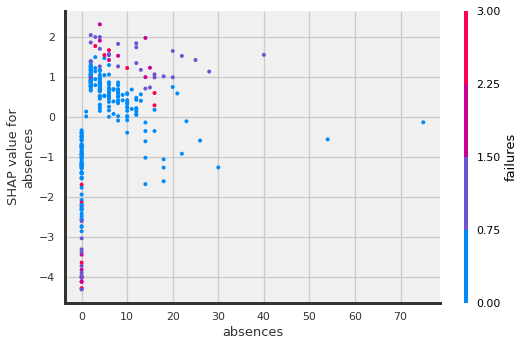

In [22]:
## Using shap_values made from shap_values = explainer(X_shap)
shap.dependence_plot("absences", shap_values.values,X_shap)

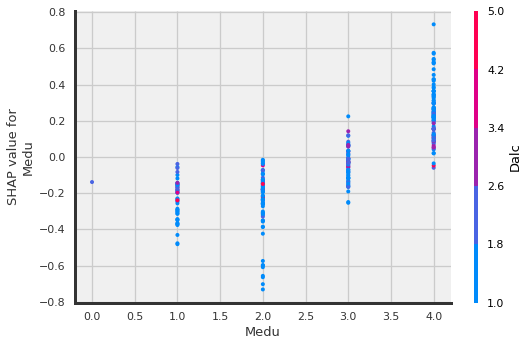

In [23]:
## Using shap_values made from shap_values = explainer(X_shap)
shap.dependence_plot("Medu", shap_values.values,X_shap)

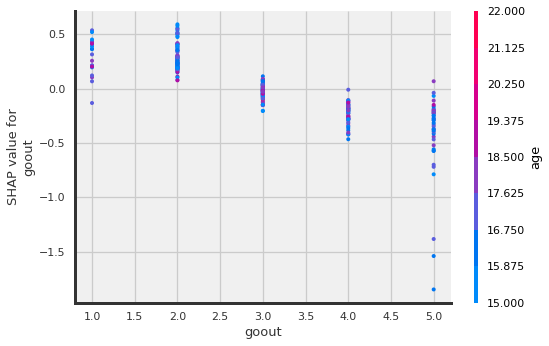

In [24]:
## Using shap_values made from shap_values = explainer(X_shap)
shap.dependence_plot("goout", shap_values.values,X_shap)

### Force Plot

>- Note: the force_plot is an interactive visualization that uses javascript. You must Trust your jupyter notebook in order to display it.
    - In the top right corner of jupyter notebook, next the kernel name (Python (dojo-env)), click the `Not Trusted` button to trust the notebook.

#### Global `shap.force_plot`

To show a global force plot:
```python
## Fore plot
shap.force_plot(explainer.expected_value[1], shap_values[:,:,1], features=X_shap)


```

#### Global Force Plot

In [25]:
## TESTING COMPLEX SHAP VALS AGAIN (Overall Forceplot)
shap.force_plot(explainer.expected_value, shap_values.values,features=X_shap)

#### Fore Plot Interpretation

- TO DO

#### Explain Individual Plot

- To show an individual data point's prediction and the factors pushing it towards one class or another.
- For now, we will randomly select a row to display, but we will revisit thoughtful selection of examples for stakeholders in our next lesson about local explanations.
```python
## Just using np to randomly select a row
row = np.random.choice(range(len(X_shap)))         
shap.force_plot(explainer.expected_value[1], shap_values[1][row], X_shap.iloc[row])
```

In [26]:
row = np.random.choice(range(len(X_shap)))
print(f"- Row #: {row}")
print(f"- Target: {y_shap.iloc[row]}")
X_shap.iloc[row].round(2)

- Row #: 85
- Target: 6.0


age                  18.0
Medu                  1.0
Fedu                  1.0
traveltime            2.0
studytime             2.0
failures              1.0
famrel                4.0
freetime              4.0
goout                 3.0
Dalc                  2.0
Walc                  3.0
health                5.0
absences              2.0
school_MS             1.0
sex_M                 1.0
address_U             0.0
famsize_LE3           1.0
Pstatus_T             1.0
Mjob_at_home          1.0
Mjob_health           0.0
Mjob_other            0.0
Mjob_services         0.0
Mjob_teacher          0.0
Fjob_at_home          0.0
Fjob_health           0.0
Fjob_other            1.0
Fjob_services         0.0
Fjob_teacher          0.0
reason_course         0.0
reason_home           0.0
reason_other          1.0
reason_reputation     0.0
guardian_father       0.0
guardian_mother       1.0
guardian_other        0.0
schoolsup_yes         0.0
famsup_yes            0.0
paid_yes              0.0
activities_y

In [27]:
## Individual forceplot (with the complex shap vals)
shap.force_plot(explainer.expected_value,shap_values= shap_values[row].values,
               features=X_shap.iloc[row])

### Waterfall Plot

In [28]:
explainer.expected_value

array([10.34317568])

In [29]:
shap_values[row]#,:,1]

.values =
array([-1.06826576e-01, -8.27475108e-02, -9.09468180e-02, -1.41339274e-02,
       -5.23458955e-02, -1.40791878e+00,  6.95681721e-03, -4.14373232e-02,
       -7.43381448e-02, -3.20156255e-02, -1.14419829e-01, -1.11251761e-01,
        2.04968238e+00,  2.65195333e-02,  4.74230874e-02, -8.60920840e-02,
        1.05248311e-01, -7.51729126e-03,  7.89352552e-02, -1.64113732e-02,
        1.35993462e-01, -2.18647657e-02,  1.99391968e-02, -1.90337616e-02,
       -1.55896265e-03, -3.25649041e-02,  2.07980786e-03, -2.77867960e-02,
        9.32572748e-02,  1.00607556e-02,  1.00138176e-01, -1.92533952e-02,
        3.49964031e-03, -4.32813322e-03, -1.97932944e-04,  3.07952569e-02,
        9.92020595e-02, -8.22436248e-03,  6.61156139e-02, -1.49940694e-02,
       -2.34602883e-01,  4.27374105e-02,  4.10531897e-02])

.base_values =
array([10.34317568])

.data =
array([18.,  1.,  1.,  2.,  2.,  1.,  4.,  4.,  3.,  2.,  3.,  5.,  2.,
        1.,  1.,  0.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  

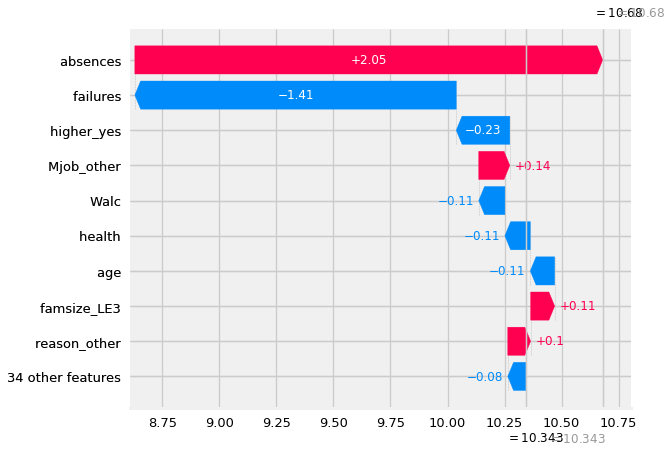

In [30]:
#source: https://towardsdatascience.com/explainable-ai-xai-a-guide-to-7-packages-in-python-to-explain-your-models-932967f0634b
shap.plots._waterfall.waterfall_legacy(explainer.expected_value[0], 
                                       shap_values[row].values,
                                       features=X_shap.iloc[row],
                                       show=True)


# BOOKMARK: stopped here 07/11/22

### Interaction Values

"*The main effects are similar to the SHAP values you would get for a linear model, and the interaction effects captures all the higher-order interactions are divide them up among the pairwise interaction terms. Note that the sum of the entire interaction matrix is the difference between the model’s current output and expected output, and so the interaction effects on the off-diagonal are split in half (since there are two of each). When plotting interaction effects the SHAP package automatically multiplies the off-diagonal values by two to get the full interaction effect.*"
- https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/tree_based_models/NHANES%20I%20Survival%20Model.html#Compute-SHAP-Interaction-Values 

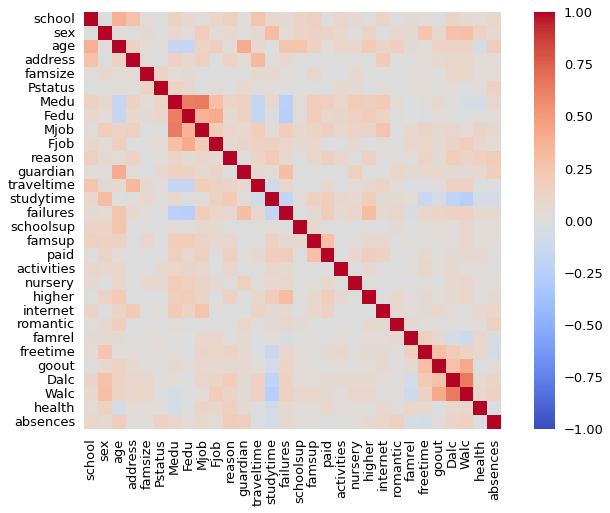

2

In [31]:
from dython.nominal import associations
res = associations(X, annot=False,cmap='coolwarm')
len(res)

- Interactions: - https://towardsdatascience.com/analysing-interactions-with-shap-8c4a2bc11c2a

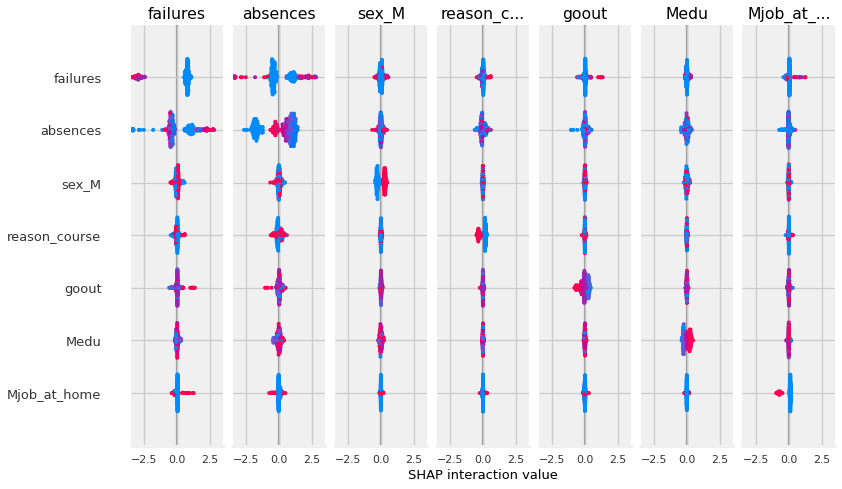

In [32]:
shap_interaction_values = explainer.shap_interaction_values(X_shap)
shap.summary_plot(shap_interaction_values,X_shap)

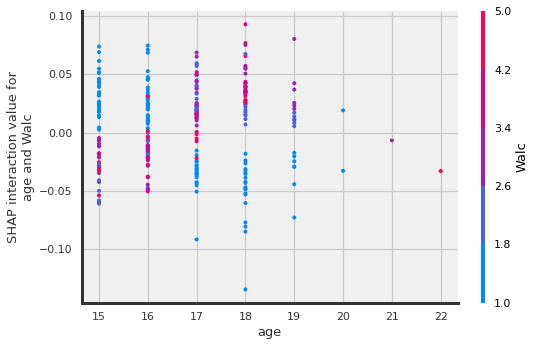

In [33]:
shap.dependence_plot(
    ("age", "Walc"),
    shap_interaction_values, X_shap,
    display_features=X_shap
)

> TO DO: read more about the interactions and add interpretation here


### `Shap Decision Plot?`

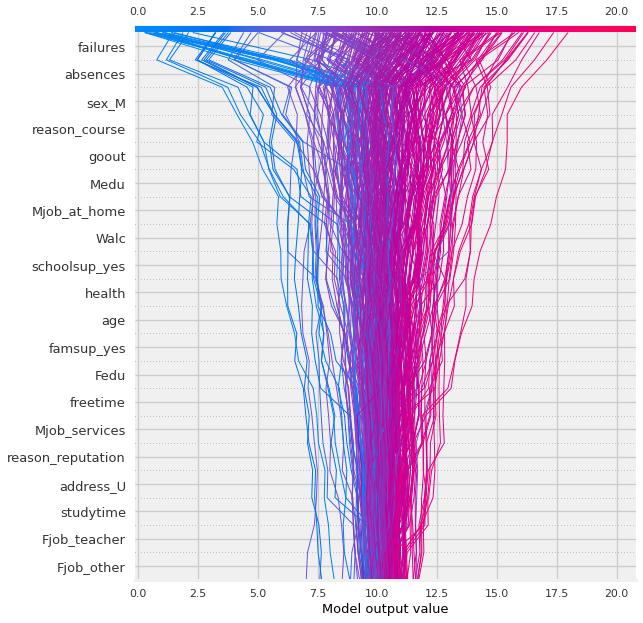

In [34]:
shap.decision_plot(explainer.expected_value, shap_values.values,X_shap)